In [2]:
import numpy as np
import pandas as pd
import os 
from sklearn import *
#import nltk
import time 

def time_elapsed(sec):
  h = int(sec/3600)
  m = int(sec/60)
  s = sec % 60
  return "{}:{:>02}:{:>05.2f}".format(h,m,s)          

In [2]:
# Load DATA
DATA_PATH = 'H:\Projekty\Predict Future Sales\data'
train = pd.read_csv(os.path.join(DATA_PATH, 'sales_train.csv')) 
cats = pd.read_csv(os.path.join(DATA_PATH, 'item_categories.csv')) 
items = pd.read_csv(os.path.join(DATA_PATH, 'items.csv')) 
shops = pd.read_csv(os.path.join(DATA_PATH, 'shops.csv')) 
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv')) 

In [3]:
# See how data looks
print(train.info())
print(train.describe())
train.head(-5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
       date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908532e+02  1.242641e+00
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00
75%      2.300000e+01  4.700000e+01  1.56

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935839,24.10.2015,33,25,7315,399.00,1.0
2935840,31.10.2015,33,25,7409,299.00,1.0
2935841,11.10.2015,33,25,7393,349.00,1.0
2935842,10.10.2015,33,25,7384,749.00,1.0


## 1. Data cleaning and modifications

### Remove outliers


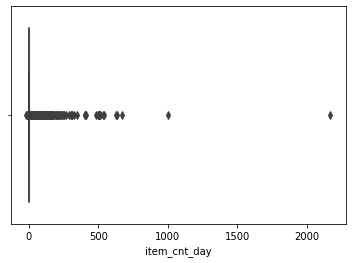

In [4]:
import seaborn as sns

sns.boxplot(x=train.item_cnt_day)

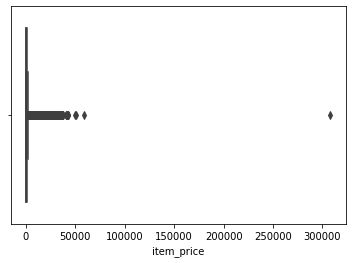

In [5]:
sns.boxplot(x=train.item_price)

In [6]:
# Take data without outliers
train = train[(train.item_price < 250000 )& (train.item_cnt_day < 1000)]

### Remove refunds

In [7]:
train = train[train.item_price > 0].reset_index(drop = True)
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0

### Cleaning and Extending shop data

In [8]:
# Cleaning shop data:
# Someone found out that these shops are duplicated
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

train.loc[train.shop_id == 40, 'shop_id'] = 39
test.loc[test.shop_id == 40, 'shop_id'] = 39

train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

#Changing shop name to extract city and category
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'

# extracting city from shop name
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )

# extracting category from shop name
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )

# lower capitals
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0].lower())

# fix city name
shops.loc[shops.city == '!якутск', 'city'] = 'якутск'

# encoding those categories
from sklearn.preprocessing import LabelEncoder
shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )

# adding coords of the shops (coords acording to user "uladzimirkapeika")
coords = dict()
coords['якутск'] = (62.028098, 129.732555, 4)
coords['адыгея'] = (44.609764, 40.100516, 3)
coords['балашиха'] = (55.8094500, 37.9580600, 1)
coords['волжский'] = (53.4305800, 50.1190000, 3)
coords['вологда'] = (59.2239000, 39.8839800, 2)
coords['воронеж'] = (51.6720400, 39.1843000, 3)
coords['выездная'] = (0, 0, 0)
coords['жуковский'] = (55.5952800, 38.1202800, 1)
coords['интернет-магазин'] = (0, 0, 0)
coords['казань'] = (55.7887400, 49.1221400, 4)
coords['калуга'] = (54.5293000, 36.2754200, 4)
coords['коломна'] = (55.0794400, 38.7783300, 4)
coords['красноярск'] = (56.0183900, 92.8671700, 4)
coords['курск'] = (51.7373300, 36.1873500, 3)
coords['москва'] = (55.7522200, 37.6155600, 1)
coords['мытищи'] = (55.9116300, 37.7307600, 1)
coords['н.новгород'] = (56.3286700, 44.0020500, 4)
coords['новосибирск'] = (55.0415000, 82.9346000, 4)
coords['омск'] = (54.9924400, 73.3685900, 4)
coords['ростовнадону'] = (47.2313500, 39.7232800, 3)
coords['спб'] = (59.9386300, 30.3141300, 2)
coords['самара'] = (53.2000700, 50.1500000, 4)
coords['сергиевпосад'] = (56.3000000, 38.1333300, 4)
coords['сургут'] = (61.2500000, 73.4166700, 4)
coords['томск'] = (56.4977100, 84.9743700, 4)
coords['тюмень'] = (57.1522200, 65.5272200, 4)
coords['уфа'] = (54.7430600, 55.9677900, 4)
coords['химки'] = (55.8970400, 37.4296900, 1)
coords['цифровой'] = (0, 0, 0)
coords['чехов'] = (55.1477000, 37.4772800, 4)
coords['ярославль'] = (57.6298700, 39.8736800, 2) 

shops['city_coord_1'] = shops['city'].apply(lambda x: coords[x][0])
shops['city_coord_2'] = shops['city'].apply(lambda x: coords[x][1])
shops['country_part'] = shops['city'].apply(lambda x: coords[x][2])

shops = shops[["shop_id", "shop_category", "shop_city", 'city_coord_1', 'city_coord_2']]

### Merging Item and Category data

In [9]:
# merge datasets
items = pd.merge(items, cats, on='item_category_id')

map_dict = { #maps of exceptional categories (according to uladzimirkapeika)
            'Чистые носители (штучные)': 'Чистые носители',
            'Чистые носители (шпиль)' : 'Чистые носители',
            'PC ': 'Аксессуары',
            'Служебные': 'Служебные '
            }
items['item_category'] = items['item_category_name'].apply(lambda x: x.split('-')[0])
items['item_category'] = items['item_category'].apply(lambda x: map_dict[x] if x in map_dict.keys() else x)
# encoding labels
items['item_category_common'] = LabelEncoder().fit_transform(items['item_category'])
items['item_category_code'] = LabelEncoder().fit_transform(items['item_category_name'])

items = items[['item_id', 'item_category_common', 'item_category_code']]

### Add revenue 

In [10]:
train["revenue"] = train["item_cnt_day"] * train["item_price"]

### Sum items by month

In [11]:
from itertools import product
# First create array with every combination of Months, shop_id and item_id
# Function "itertools.product give us array of every combination of given vectors"
df = []
columns  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = train[train.date_block_num == i] # we are taking sub-arrays for every month
    df.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) )) ) 
    # here we append every combination of month (i), unique shops in this months and uniqie items in this month
    
df = pd.DataFrame( np.vstack(df), columns = columns, dtype=np.int32 ) # create pd.DataFrame
df.sort_values(columns, inplace = True )

# Month sales
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)

df = pd.merge(df, group, on=columns, how='left')
df['item_cnt_month'] = (df['item_cnt_month'].fillna(0).clip(0,20))
df.head(5)

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


### Merge datasets

In [12]:
# concat test and df
test['date_block_num'] = 34
df = pd.concat([df, test], ignore_index=True, sort=False, keys=columns)
df.fillna(0, inplace=True)

# merge previously modifyied dataframes with df
df = pd.merge( df, shops, on = ["shop_id"], how = "left" )
df = pd.merge(df, items, on = ["item_id"], how = "left")

### Add coresponding months

In [13]:
# based on date_block_num define number of calendar months
def get_months(i):
    if (i <= 11):
        return i+1
    if (i > 11) & (i <= 23):
        return (i-11)
    if (i > 23):
        return (i-23)
        
map_dict = {i: get_months(i) for i in range(35)}
df['month'] = df['date_block_num'].apply(lambda x: map_dict[x])

### Add features that tells which items are new and which were bought previously

In [14]:
# find minimum date for bought item in the shop
first_shop_item_buought = df.groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()

# write this date into other column
first_shop_item_buought['first_shop_date_block_num'] = first_shop_item_buought['date_block_num']

# merge dataframes
df = pd.merge(df, first_shop_item_buought[['item_id', 'shop_id', 'first_shop_date_block_num']], on=['item_id', 'shop_id'], how='left')

# fill column with 100 if item was never bought
df['first_shop_date_block_num'].fillna(100, inplace=True)

# column that tels if the item was bought previously 
df['shop_item_sold_before'] = (df['first_shop_date_block_num'] < df['date_block_num']).astype('int8')

# fill with 0 if there would be nan
df['shop_item_sold_before'].fillna(0, inplace=True)



# now the same, but for shop category, not for specific shop

# find minimum date for bought item in the category of shops
first_cat_shop_item_buought = df.groupby(['shop_category', 'item_id'])['date_block_num'].min().reset_index()

# write this date into other column
first_cat_shop_item_buought['first_shop_cat_date_block_num'] = first_cat_shop_item_buought['date_block_num']

# merge dataframes
df = pd.merge(df, first_cat_shop_item_buought[['item_id', 'shop_category', 'first_shop_cat_date_block_num']], on=['item_id', 'shop_category'], how='left')

# fill column with 100 if item was never bought
df['first_shop_cat_date_block_num'].fillna(100, inplace=True)

# column that tels if the item was bought previously 
df['shop_cat_item_sold_before'] = (df['first_shop_cat_date_block_num'] < df['date_block_num']).astype('int8')

# fill with 0 if there would be nan
df['shop_cat_item_sold_before'].fillna(0, inplace=True)



# see if item is new
new_item_block = df.groupby(['item_id'])['date_block_num'].min().reset_index()

# get date of first interaction with item
new_item_block['item_first_interaction'] = new_item_block['date_block_num']

# merge dataframes
df = pd.merge(df, new_item_block[['item_id', 'date_block_num', 'item_first_interaction']], on=['item_id', 'date_block_num'], how='left')
df['item_first_interaction'].fillna(100, inplace=True)

# if interacion already was, put 1 in new column
df.loc[(df['item_first_interaction'] > df['date_block_num']),'item_sold_before']= 1 
df['item_sold_before'].fillna(0, inplace=True)
df['item_sold_before'] = df['item_sold_before'].astype('int8')
df.drop(['item_first_interaction'], axis=1, inplace=True)


## 2.0 Add Lag features

In [15]:
# Define a lag feature function
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [16]:
#Add sales lags for last 3 months
df = lag_feature(df, [1, 2, 3], ["item_cnt_month"])


item_cnt_month


In [17]:
#Add avg shop/item price

index_cols = ['shop_id', 'item_id', 'date_block_num']
group = train.groupby(index_cols)['item_price'].mean().reset_index().rename(columns={"item_price": "avg_shop_price"}, errors="raise")
df = pd.merge(df, group, on=index_cols, how='left')

df['avg_shop_price'] = (df['avg_shop_price']
                                .fillna(0)
                                .astype(np.float16))

index_cols = ['item_id', 'date_block_num']
group = train.groupby(['date_block_num','item_id'])['item_price'].mean().reset_index().rename(columns={"item_price": "avg_item_price"}, errors="raise")


df = pd.merge(df, group, on=index_cols, how='left')
df['avg_item_price'] = (df['avg_item_price']
                                .fillna(0)
                                .astype(np.float16))

df['item_shop_price_avg'] = (df['avg_shop_price'] - df['avg_item_price']) / df['avg_item_price']
df['item_shop_price_avg'].fillna(0, inplace=True)

df = lag_feature(df, [1, 2, 3], ['item_shop_price_avg'])
df.drop(['avg_shop_price', 'avg_item_price', 'item_shop_price_avg'], axis=1, inplace=True)

item_shop_price_avg


In [18]:
#Add target encoding for items for last 3 months 
item_id_target_mean = df.groupby(['date_block_num','item_id'])['item_cnt_month'].mean().reset_index().rename(columns={"item_cnt_month": "item_target_enc"}, errors="raise")
df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id'], how='left')

df['item_target_enc'] = (df['item_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], ['item_target_enc'])
df.drop(['item_target_enc'], axis=1, inplace=True)

item_target_enc


In [19]:
#Add target encoding for item/city for last 3 months 
item_id_target_mean = df.groupby(['date_block_num','item_id', 'shop_city'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_loc_target_enc"}, errors="raise")
df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id', 'shop_city'], how='left')

df['item_loc_target_enc'] = (df['item_loc_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], ['item_loc_target_enc'])
df.drop(['item_loc_target_enc'], axis=1, inplace=True)

item_loc_target_enc


In [20]:
#Add target encoding for item/shop for last 3 months 
item_id_target_mean = df.groupby(['date_block_num','item_id', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_shop_target_enc"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id', 'shop_id'], how='left')

df['item_shop_target_enc'] = (df['item_shop_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], ['item_shop_target_enc'])
df.drop(['item_shop_target_enc'], axis=1, inplace=True)

item_shop_target_enc


In [21]:
#For new items add avg category sales for last 3 months
item_id_target_mean = df[df['item_sold_before'] == 1].groupby(['date_block_num','item_category_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "new_item_cat_avg"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_category_code'], how='left')

df['new_item_cat_avg'] = (df['new_item_cat_avg']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], ['new_item_cat_avg'])
df.drop(['new_item_cat_avg'], axis=1, inplace=True)

new_item_cat_avg


In [22]:
#For new items add avg category sales in a separate store for last 3 months
item_id_target_mean = df[df['item_sold_before'] == 1].groupby(['date_block_num','item_category_code', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "new_item_shop_cat_avg"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_category_code', 'shop_id'], how='left')

df['new_item_shop_cat_avg'] = (df['new_item_shop_cat_avg']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], ['new_item_shop_cat_avg'])
df.drop(['new_item_shop_cat_avg'], axis=1, inplace=True)

new_item_shop_cat_avg


## Save/Load downsize data

In [23]:
df.fillna(0, inplace=True)
# drop first 2 months becouse there is no lags
df = df[(df['date_block_num'] > 2)]

In [25]:
print(df.info())
df.head(-5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935845 entries, 0 to 2935844
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
 6   revenue         float64
dtypes: float64(3), int64(3), object(1)
memory usage: 156.8+ MB
None


,date_block_num,shop_id,item_id,item_cnt_month,ID,shop_category,shop_city,city_coord_1,city_coord_2,item_category_common,...,item_loc_target_enc_lag_3,item_shop_target_enc_lag_1,item_shop_target_enc_lag_2,item_shop_target_enc_lag_3,new_item_cat_avg_lag_1,new_item_cat_avg_lag_2,new_item_cat_avg_lag_3,new_item_shop_cat_avg_lag_1,new_item_shop_cat_avg_lag_2,new_item_shop_cat_avg_lag_3
1122795,3,2,27,0.0,0.0,8,0,44.609764,40.100516,5,...,1.0,0.0,0.0,1.0,0.869141,0.892090,0.000000,0.531250,0.272217,0.000000
1122796,3,2,28,0.0,0.0,8,0,44.609764,40.100516,8,...,0.0,0.0,0.0,0.0,1.124023,1.045898,0.000000,0.401855,0.268555,0.000000
1122797,3,2,30,0.0,0.0,8,0,44.609764,40.100516,11,...,0.0,1.0,0.0,0.0,0.250977,0.232178,0.000000,0.025177,0.016159,0.000000
1122798,3,2,31,1.0,0.0,8,0,44.609764,40.100516,11,...,0.0,1.0,4.0,0.0,0.166382,0.166504,0.000000,0.021698,0.023254,0.000000
1122799,3,2,32,0.0,0.0,8,0,44.609764,40.100516,11,...,0.0,0.0,0.0,0.0,0.250977,0.232178,0.000000,0.025177,0.016159,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056267,34,45,3280,0.0,214190.0,8,19,53.200070,50.150000,13,...,0.0,0.0,0.0,0.0,0.180542,0.177734,0.214722,0.113037,0.074097,0.105835
11056268,34,45,4393,0.0,214191.0,8,19,53.200070,50.150000,5,...,0.0,0.0,0.0,0.0,0.229492,0.257324,0.329346,0.133301,0.206909,0.233276
11056269,34,45,4352,0.0,214192.0,8,19,53.200070,50.150000,5,...,0.0,0.0,0.0,0.0,0.229492,0.257324,0.329346,0.133301,0.206909,0.233276
11056270,34,45,18049,0.0,214193.0,8,19,53.200070,50.150000,14,...,0.0,0.0,0.0,0.0,0.324707,0.254883,0.388916,0.145508,0.109863,0.220947


In [27]:
#Save dataset
#df.drop(['ID'], axis=1, inplace=True, errors='ignore')
#df.to_pickle('H:\Projekty\Predict Future Sales\data\df.pkl')


In [3]:
df = pd.read_pickle('H:\Projekty\Predict Future Sales\data\df2.pkl')
#del df

In [28]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df
#downsize from 1.5gb to 0.8gb
#df = downcast_dtypes(df)
#df.to_pickle('H:\Projekty\Predict Future Sales\data\df2.pkl')


## 3.0 Prepare Training

In [4]:
X_train = df[df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = df[df.date_block_num < 33]['item_cnt_month']
X_valid = df[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = df[df.date_block_num == 33]['item_cnt_month']
X_test = df[df.date_block_num == 34].drop(['item_cnt_month'], axis=1)
del df

In [5]:
from xgboost import XGBRegressor


In [20]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=100,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.08,
    tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

print(f' time elapsed: {time_elapsed(time.time() - ts)}')

[0]	validation_0-rmse:1.19017	validation_1-rmse:1.12630
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.15182	validation_1-rmse:1.09508
[2]	validation_0-rmse:1.11883	validation_1-rmse:1.07076
[3]	validation_0-rmse:1.08843	validation_1-rmse:1.04734
[4]	validation_0-rmse:1.06169	validation_1-rmse:1.02770
[5]	validation_0-rmse:1.03872	validation_1-rmse:1.01031
[6]	validation_0-rmse:1.01777	validation_1-rmse:0.99542
[7]	validation_0-rmse:1.00053	validation_1-rmse:0.98333
[8]	validation_0-rmse:0.98397	validation_1-rmse:0.97179
[9]	validation_0-rmse:0.96967	validation_1-rmse:0.96202
[10]	validation_0-rmse:0.95753	validation_1-rmse:0.95471
[11]	validation_0-rmse:0.94757	validation_1-rmse:0.94900
[12]	validation_0-rmse:0.93831	validation_1-rmse:0.94413
[13]	validation_0-rmse:0.93010	validation_1-rmse:0.93927
[14]	validation_0-rmse:0.92303	validation_1-rmse:0.93

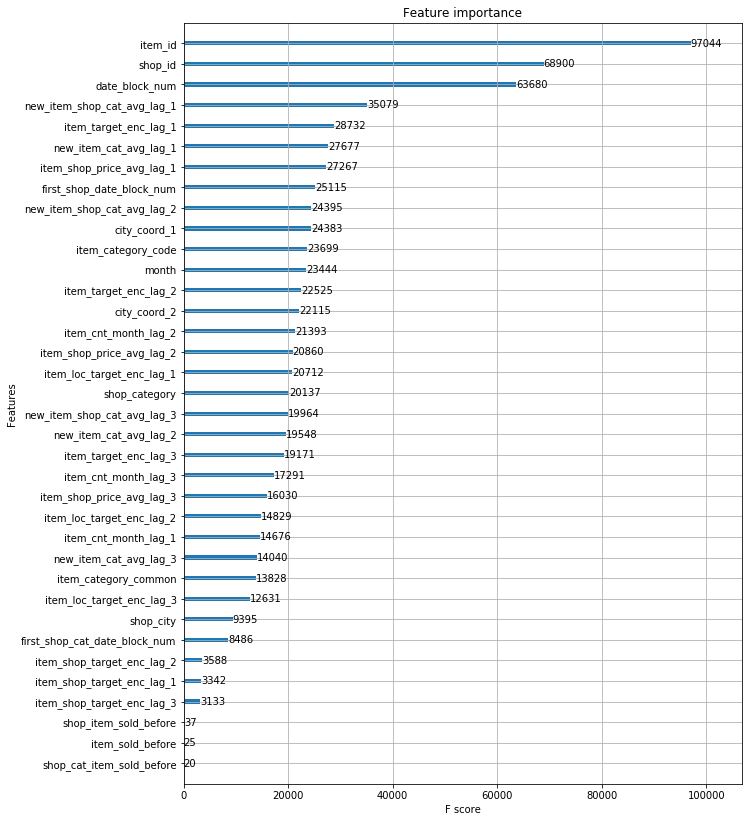

In [8]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

In [12]:
DATA_PATH = 'H:\Projekty\Predict Future Sales\data'
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv')) 
Y_test = model.predict(X_test).clip(0, 20)
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('H:/Projekty/Predict Future Sales/data/submission2.csv', index=False)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 37-38: truncated \xXX escape (<ipython-input-12-664033155d64>, line 8)